In [1]:
# 引入第三方依赖库
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 设置数据集路径
data_dir  = './data_set'

classes = os.listdir(data_dir)

# 输出数据集分类
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'README.md', 'trash']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# transforms.Resize((256, 256))，将图像调整为256x256的大小，以及transforms.ToTensor()，将图像转换为张量形式。
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# 加载数据集
dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
import matplotlib.pyplot as plt
import matplotlib

# 使用matplotlib.use('TkAgg')将绘图的后端设置为TkAgg，这是一种图形用户界面后端，用于在Tkinter中显示绘图
matplotlib.use('TkAgg')

# %matplotlib inline是Jupyter Notebook中的一个魔术命令，用于在Notebook中显示绘图结果。
%matplotlib inline

# 定义了一个名为show_sample的函数，该函数用于显示图像样本。它接受两个参数，img表示图像数据，label表示图像的标签。
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


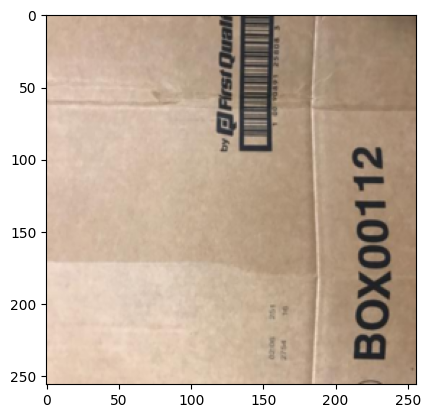

In [5]:
# dataset[1]会返回一个元组，其中第一个元素是图像数据img，第二个元素是标签label。
# 然后，调用show_sample(img, label)函数来显示图像样本。show_sample函数会打印出图像的标签和类别，并显示图像。这样，你就可以看到索引为1的图像样本以及它对应的标签和类别。
img, label = dataset[1]
show_sample(img, label)

In [6]:
# torch.manual_seed()函数是PyTorch中用于设置随机数生成器种子的函数。通过设置随机种子，可以使得代码在每次运行时产生相同的随机数序列，从而使得结果可重复。

# 在这段代码中，random_seed被设置为951448078，然后调用torch.manual_seed(random_seed)函数将随机种子设置为这个值。这样，在后续的使用随机数的操作中，如果使用了相同的随机种子，就能够得到相同的随机数序列。

# 这种设置随机种子的方式常用于机器学习任务中，特别是在需要保证实验结果可复现性时非常有用。通过设置相同的随机种子，可以使得模型的训练过程和结果在不同的运行中保持一致。
random_seed = 951448078
torch.manual_seed(random_seed)

In [7]:
# 使用random_split()函数将给定的数据集dataset随机拆分成训练集、验证集和测试集。
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [8]:
# DataLoader是PyTorch中用于批量加载数据的类。它能够将数据集分成多个批次，并提供了多线程加载和数据打乱等功能。
from torch.utils.data.dataloader import DataLoader

# batch_size变量定义了每个批次的样本数量，这里设置为32。即每次加载32个样本作为一个批次。
# 调整大小防止撑爆 GPU 内存
batch_size = 8

In [9]:
# 使用DataLoader类创建了训练集和验证集的数据加载器，并设置对应参数。
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [10]:
from torchvision.utils import make_grid

# 定义了一个 show_batch 的函数，用于显示一个数据加载器中的一个批次的图像样本。
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

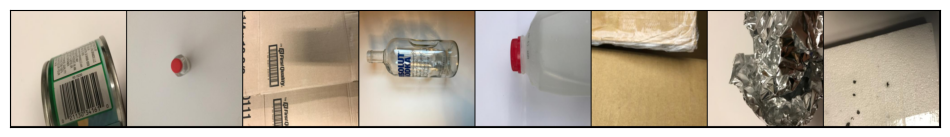

In [11]:
show_batch(train_dl)

In [12]:
# 定义 accuracy 函数和 ImageClassificationBase 类 是的 PyTorch 模型基类。
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# ImageClassificationBase 是继承 自nn.Module 的基类，用于构建图像分类模型。
class ImageClassificationBase(nn.Module):
    
    # training_step方法接受一个批次的图像样本和对应的标签
    # 将图像样本传递给模型，得到模型的输出。然后，使用F.cross_entropy函数计算模型输出和真实标签之间的交叉熵损失。最后，返回损失值。
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    # validation_epoch_end方法接受一个包含多个validation_step输出的列表。首先，从每个输出中提取出验证集损失和准确率，并计算它们的平均值。然后，返回一个字典，包含平均验证集损失和准确率
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # epoch_end方法用于在每个训练轮结束时打印出训练集损失、验证集损失和准确率
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
# 定义 ResNet的图像分类模型，并创建 ResNet类的实例model
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(weights=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    # forward方法定义了模型的前向传播过程。它接受一个输入张量xb，将其传递给self.network得到模型的输出。然后，使用torch.sigmoid函数对输出进行激活，将输出值限制在0到1之间。
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

D:\project\python_project\trash\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# 定义 辅助函数和 DeviceDataLoader 类，用于将数据加载到指定设备上。
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
# 调用get_default_device函数获取默认设备，并将结果赋值给变量device
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [17]:
# 定义了两个函数 evaluate 和 fit ，用于模型的评估和训练。
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        print(result)
        if result['val_acc'] > best_acc:
            # 保存模型
            torch.save(model,'best_model.pth')
            print("best model saved at epoch {}".format(epoch+1))
            best_acc = result['val_acc']
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(ResNet(), device)
evaluate(model, val_dl)

{'val_loss': 1.8014177083969116, 'val_acc': 0.08522727340459824}

In [19]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

{'val_loss': 1.214633822441101, 'val_acc': 0.8409090638160706}
best model saved at epoch 1
Epoch 1: train_loss: 1.4045, val_loss: 1.2146, val_acc: 0.8409
{'val_loss': 1.1629643440246582, 'val_acc': 0.8977272510528564}
best model saved at epoch 2
Epoch 2: train_loss: 1.2121, val_loss: 1.1630, val_acc: 0.8977
{'val_loss': 1.1345160007476807, 'val_acc': 0.9034090638160706}
best model saved at epoch 3
Epoch 3: train_loss: 1.1712, val_loss: 1.1345, val_acc: 0.9034
{'val_loss': 1.158963680267334, 'val_acc': 0.8806818127632141}
Epoch 4: train_loss: 1.1356, val_loss: 1.1590, val_acc: 0.8807
{'val_loss': 1.1315581798553467, 'val_acc': 0.8920454382896423}
Epoch 5: train_loss: 1.1182, val_loss: 1.1316, val_acc: 0.8920
{'val_loss': 1.1374812126159668, 'val_acc': 0.9034090638160706}
Epoch 6: train_loss: 1.0925, val_loss: 1.1375, val_acc: 0.9034
{'val_loss': 1.1349499225616455, 'val_acc': 0.9147727489471436}
best model saved at epoch 7
Epoch 7: train_loss: 1.0854, val_loss: 1.1349, val_acc: 0.9148
{

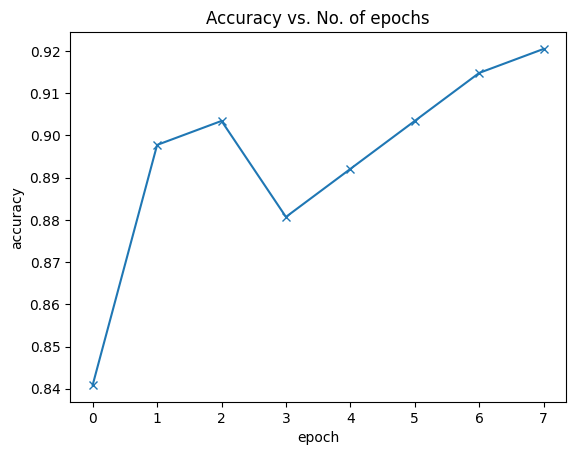

In [20]:
# 定义plot_accuracies函数，用于绘制模型在每个轮次中的准确率变化曲线。
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

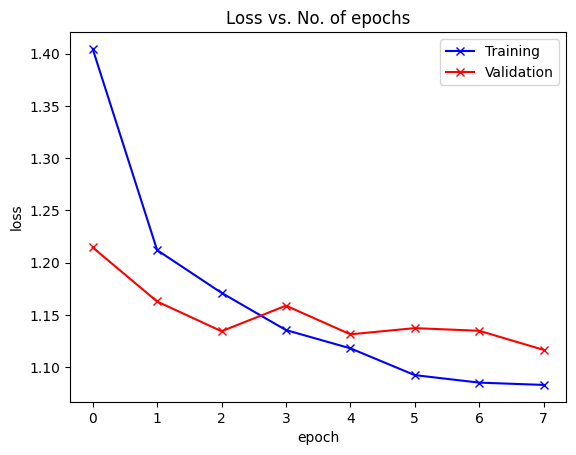

In [21]:
# 定义plot_losses函数，用于绘制模型在每个轮次中的训练损失和验证损失变化曲线。
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [22]:
# # 定义 predict_image函数，用于对一张图像进行预测，并返回预测结果。
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


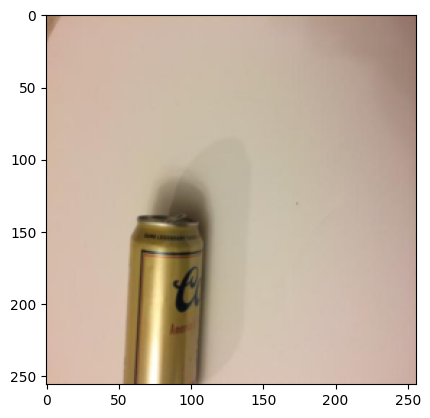

In [34]:
# 从测试数据集test_ds中获取第4个样本的图像和标签，并将其分别赋值给变量img和label
img, label = test_ds[87]
plt.imshow(img.permute(1, 2, 0))

# 加载模型
now_model = torch.load('./best_model.pth')

# 输出 label 和 预测结果
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, now_model))